In [1]:
import sys
from transformers import AutoTokenizer
import torch
import torch.nn.functional as F
import json
import os
import PIL
import argparse
import random
from tqdm import tqdm
import numpy as np
from matplotlib import pyplot as plt

sys.path.append('ANONYMOUS_ROOTDIR/develop/open-world/transfer-pretrain/')
from model.pretrain_model import JointNCEModel
from data.pretrain_loader import PretrainDataset

In [8]:
# state_dict = torch.load('ANONYMOUS_ROOTDIR/develop/open-world/transfer-pretrain/convirt_pretrained_full.pt')

model = JointNCEModel(state_dict['config'])

# model.text_encoder.load_state_dict(state_dict['text_encoder'], strict=False)
# model.image_encoder.load_state_dict(state_dict['image_encoder'], strict=False)
# model.text_proj.load_state_dict(state_dict['text_proj'], strict=False)
# model.image_proj.load_state_dict(state_dict['image_proj'], strict=False)

Some weights of the model checkpoint at emilyalsentzer/Bio_ClinicalBERT were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [3]:
base_dir = "ANONYMOUS_ROOTDIR/develop/data-open/mimic-cxr-jpg-resized"

def parse_args():
    parser = argparse.ArgumentParser()
    parser.add_argument('--data_dir', type=str, help="Data directory with train and valid indexed report files.", default=None)
    parser.add_argument('--meta_file', type=str, default=f'{base_dir}/meta.json', help="Dataset meta file.")
    parser.add_argument('--img_dir', type=str, default=f'{base_dir}/files/', help="Directory to load image data from.")
    parser.add_argument('--local_img_dir', type=str, default=f'{base_dir}/files/', help="Directory to load image data from.")
    parser.add_argument('--image_encoder', type=str, default='resnet50', help="Name of the model architecture.")
    parser.add_argument('--bert_name', type=str, default='emilyalsentzer/Bio_ClinicalBERT', help="Name of the pretrained BERT model.")
    parser.add_argument('--imsize', type=int, default=224, help="Size of image.")
    parser.add_argument('--augment_p', type=float, default=0.8, help="Probability for image augmentation.")
    parser.add_argument('--dropout', type=float, default=0.2, help="Dropout rate.")
    parser.add_argument('--finetune_text_encoder', dest='freeze_text_encoder', action='store_false', help="Whether to finetune text encoder.")

    parser.add_argument('--num_clf_layer', type=int, default=2, help="Number of layers to use for NN classifier.")
    parser.add_argument('--clf_hidden_dim', type=int, default=512, help="Number of hidden dims for NN classifier.")
    parser.add_argument('--pool', choices=['cls', 'mean', 'max'], default='mean', help="Type of pooling to use for text encoder.")

    parser.add_argument('--fp', dest='amp', action='store_false', help="Use full precision training; by default use mixed precision.")
    parser.add_argument('--rih', action='store_true', help="Train on the RIH data; use corresponding data loaders.")

    parser.add_argument('--batch_size', type=int, default=32)
    parser.add_argument('--num_epoch', type=int, default=200)
    parser.add_argument('--steps_per_epoch', type=int, default=5000)
    parser.add_argument('--optim', type=str, default='adam', help='sgd, adagrad, adam, adamw or adamax.')
    parser.add_argument('--lr', type=float, default=1e-4)
    parser.add_argument('--weight_decay', type=float, default=1e-6)
    parser.add_argument('--patience', type=int, default=5)
    parser.add_argument('--annealing_factor', type=float, default=0.5)
    parser.add_argument('--log_interval', type=int, default=100)
    parser.add_argument('--num_workers', type=int, default=4)
    parser.add_argument('--pin_memory', action='store_true')
    parser.add_argument('--save_dir', type=str, default=None, help="Directory to save the trained model; if None will use id to look up")
    parser.add_argument('--root_dir', type=str, default='saved_models/pretrain', help="Root directory for model saving.")
    parser.add_argument('--id', type=int, default=0, help="An id of the training run")
    parser.add_argument('--seed', type=int, default=1234)

    args = parser.parse_args("")
    return args

args = parse_args()
opt = vars(args)

In [4]:
tokenizer = AutoTokenizer.from_pretrained(opt['bert_name'])

dataset = PretrainDataset(
    indexed_file=f"{base_dir}/reports_indexed.json",
    meta_file=f"{base_dir}/meta.json",
    img_dir=f"{base_dir}/files/",
    opt=opt,
    tokenizer=tokenizer,
    evaluation=False,
    imsize=opt['imsize'],
    augment_p=opt['augment_p']
)

In [9]:
# random sample 500 idxs from dataset
random.seed(1234)
idxs = random.sample(range(len(dataset)), 500)
all_img_v, all_text_v = [], []

with torch.no_grad():
    for idx in tqdm(idxs):
        image, text_ids = dataset[idx]
        image = torch.tensor(image).unsqueeze(0)
        text_ids = torch.tensor(text_ids).unsqueeze(0)
        text_attention_mask = torch.ones(len(text_ids[0])).unsqueeze(0)
        
        img_v = model.image_encoder(image)
        text_v = model.text_encoder(text_ids, text_attention_mask)

        img_v = model.image_proj(img_v) # batch_size, dim
        text_v = model.text_proj(text_v) # batch_size, dim

        # normalize for cosine similarity
        img_v = F.normalize(img_v, dim=1)
        text_v = F.normalize(text_v, dim=1)

        all_img_v.append(img_v)
        all_text_v.append(text_v)

  0%|          | 0/500 [00:00<?, ?it/s]/tmp/ipykernel_2388247/3629298052.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image = torch.tensor(image).unsqueeze(0)
100%|██████████| 500/500 [00:48<00:00, 10.39it/s]


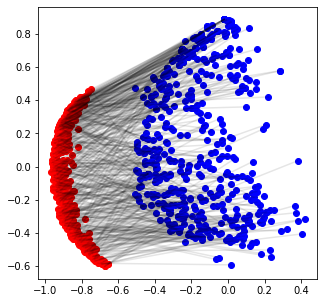

In [7]:
# Use PCA to reduce dimensionality
all_img_features = torch.cat(all_img_v, dim=0)
all_text_features = torch.cat(all_text_v, dim=0)

np.save('features_convirt.npy', [all_img_features.numpy(), all_text_features.numpy()])

def svd(X, n_components=2):
    # using SVD to compute eigenvectors and eigenvalues
    # M = np.mean(X, axis=0)
    # X = X - M
    U, S, Vt = np.linalg.svd(X)
    # print(S)
    return U[:, :n_components] * S[:n_components]

features_2d = svd(torch.cat([all_img_features, all_text_features], 0).detach().numpy())
plt.figure(figsize=(5, 5))
plt.scatter(features_2d[:-len(all_img_features), 0], features_2d[:-len(all_img_features), 1], c='red')
plt.scatter(features_2d[-len(all_img_features):, 0], features_2d[-len(all_img_features):, 1], c='blue')
# connect the dots
for i in range(len(all_img_features)):
    plt.plot([features_2d[i, 0], features_2d[len(all_img_features)+i, 0]], [features_2d[i, 1], features_2d[len(all_img_features)+i, 1]], c='black', alpha=0.1)

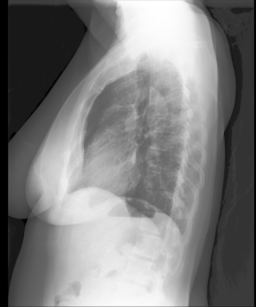

In [7]:
PIL.Image.open(f"ANONYMOUS_ROOTDIR/develop/data-open/mimic-cxr-jpg-resized/files/p10/p10417982/s55446246/acc7e69b-10a8b603-509a12b8-ed440a65-9469059b.png")

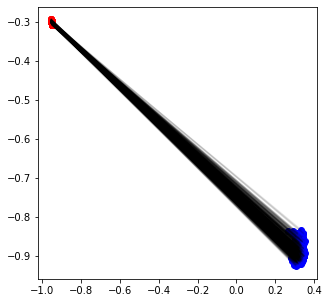

In [10]:
# Use PCA to reduce dimensionality
all_img_features = torch.cat(all_img_v, dim=0)
all_text_features = torch.cat(all_text_v, dim=0)

np.save('features_convirt_random.npy', [all_img_features.numpy(), all_text_features.numpy()])

def svd(X, n_components=2):
    # using SVD to compute eigenvectors and eigenvalues
    # M = np.mean(X, axis=0)
    # X = X - M
    U, S, Vt = np.linalg.svd(X)
    # print(S)
    return U[:, :n_components] * S[:n_components]

features_2d = svd(torch.cat([all_img_features, all_text_features], 0).detach().numpy())
plt.figure(figsize=(5, 5))
plt.scatter(features_2d[:-len(all_img_features), 0], features_2d[:-len(all_img_features), 1], c='red')
plt.scatter(features_2d[-len(all_img_features):, 0], features_2d[-len(all_img_features):, 1], c='blue')
# connect the dots
for i in range(len(all_img_features)):
    plt.plot([features_2d[i, 0], features_2d[len(all_img_features)+i, 0]], [features_2d[i, 1], features_2d[len(all_img_features)+i, 1]], c='black', alpha=0.1)